In [41]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [42]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [44]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.


100%|██████████| 9912422/9912422 [00:00<00:00, 12908175.85it/s]


Extracting input/data\MNIST\raw\train-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting input/data\MNIST\raw\train-labels-idx1-ubyte.gz to input/data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 8516960.79it/s]


Extracting input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4554274.15it/s]

Extracting input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to input/data\MNIST\raw



# Generator

In [45]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [47]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [48]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [49]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [50]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [51]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [52]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [53]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [54]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:37,  3.16it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


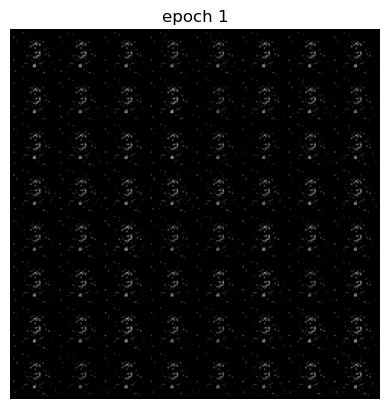

Epoch 1 of 200
Generator loss: 1.33651803, Discriminator loss: 0.90914511


118it [00:46,  2.52it/s]                         


Epoch 2 of 200
Generator loss: 1.96322100, Discriminator loss: 1.30171021


118it [00:46,  2.56it/s]                         


Epoch 3 of 200
Generator loss: 2.82931469, Discriminator loss: 0.90094910


118it [00:45,  2.57it/s]                         


Epoch 4 of 200
Generator loss: 3.17687069, Discriminator loss: 0.85476300


118it [00:44,  2.64it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


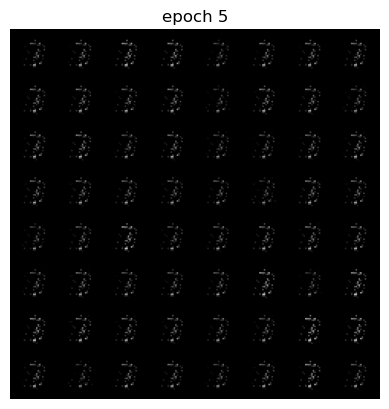

Epoch 5 of 200
Generator loss: 3.13317780, Discriminator loss: 1.08933296


118it [00:47,  2.47it/s]                         


Epoch 6 of 200
Generator loss: 1.82216519, Discriminator loss: 1.05316023


118it [00:46,  2.55it/s]                         


Epoch 7 of 200
Generator loss: 1.58330038, Discriminator loss: 0.93355367


118it [00:45,  2.58it/s]                         


Epoch 8 of 200
Generator loss: 2.07868647, Discriminator loss: 0.76322448


118it [00:46,  2.55it/s]                         


Epoch 9 of 200
Generator loss: 1.91426004, Discriminator loss: 1.14709891


118it [00:44,  2.62it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


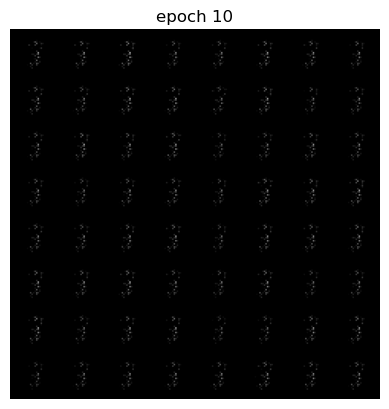

Epoch 10 of 200
Generator loss: 1.70598330, Discriminator loss: 0.87562359


118it [00:46,  2.54it/s]                         


Epoch 11 of 200
Generator loss: 2.82990414, Discriminator loss: 0.98194212


118it [00:44,  2.68it/s]                         


Epoch 12 of 200
Generator loss: 2.10919884, Discriminator loss: 0.89227277


118it [00:46,  2.53it/s]                         


Epoch 13 of 200
Generator loss: 1.92711067, Discriminator loss: 0.92362253


118it [00:48,  2.45it/s]                         


Epoch 14 of 200
Generator loss: 1.96542894, Discriminator loss: 0.86599697


118it [00:44,  2.65it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


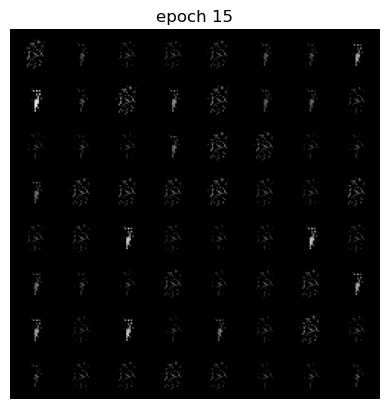

Epoch 15 of 200
Generator loss: 2.33124409, Discriminator loss: 0.77384428


118it [00:46,  2.53it/s]                         


Epoch 16 of 200
Generator loss: 3.22157718, Discriminator loss: 0.83431455


118it [00:48,  2.44it/s]                         


Epoch 17 of 200
Generator loss: 2.33759967, Discriminator loss: 0.79473278


118it [00:47,  2.49it/s]                         


Epoch 18 of 200
Generator loss: 2.35839837, Discriminator loss: 0.71278756


118it [00:47,  2.51it/s]                         


Epoch 19 of 200
Generator loss: 3.11098200, Discriminator loss: 0.50163694


118it [00:46,  2.56it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


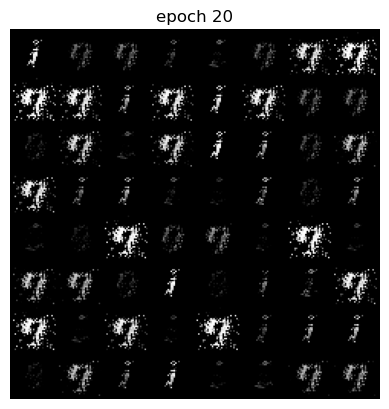

Epoch 20 of 200
Generator loss: 2.49152622, Discriminator loss: 0.72877207


118it [00:46,  2.52it/s]                         


Epoch 21 of 200
Generator loss: 1.94946750, Discriminator loss: 0.79026601


118it [00:46,  2.53it/s]                         


Epoch 22 of 200
Generator loss: 2.52253841, Discriminator loss: 0.60260259


118it [00:48,  2.44it/s]                         


Epoch 23 of 200
Generator loss: 2.80542440, Discriminator loss: 0.51532130


118it [00:45,  2.59it/s]                         


Epoch 24 of 200
Generator loss: 2.87462141, Discriminator loss: 0.62916426


118it [00:44,  2.66it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


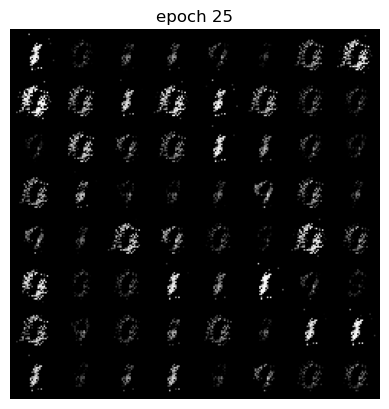

Epoch 25 of 200
Generator loss: 2.33246000, Discriminator loss: 0.59134942


118it [00:47,  2.49it/s]                         


Epoch 26 of 200
Generator loss: 2.55373640, Discriminator loss: 0.64608362


118it [00:44,  2.64it/s]                         


Epoch 27 of 200
Generator loss: 3.01176689, Discriminator loss: 0.49788671


118it [00:44,  2.64it/s]                         


Epoch 28 of 200
Generator loss: 2.82549647, Discriminator loss: 0.53127875


118it [00:47,  2.51it/s]                         


Epoch 29 of 200
Generator loss: 2.85519582, Discriminator loss: 0.47329721


118it [00:48,  2.44it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


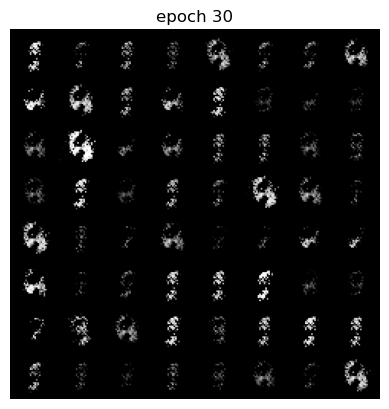

Epoch 30 of 200
Generator loss: 3.19029852, Discriminator loss: 0.48923464


118it [00:44,  2.64it/s]                         


Epoch 31 of 200
Generator loss: 3.19487154, Discriminator loss: 0.54873307


118it [00:46,  2.52it/s]                         


Epoch 32 of 200
Generator loss: 3.04776048, Discriminator loss: 0.45168074


118it [00:47,  2.51it/s]                         


Epoch 33 of 200
Generator loss: 2.72505766, Discriminator loss: 0.51707021


118it [00:47,  2.50it/s]                         


Epoch 34 of 200
Generator loss: 2.84643055, Discriminator loss: 0.57657156


118it [00:46,  2.53it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


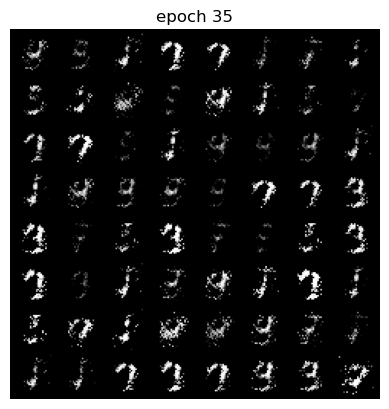

Epoch 35 of 200
Generator loss: 3.07792257, Discriminator loss: 0.47678131


118it [00:46,  2.52it/s]                         


Epoch 36 of 200
Generator loss: 3.08527769, Discriminator loss: 0.50710126


118it [00:47,  2.48it/s]                         


Epoch 37 of 200
Generator loss: 2.62417461, Discriminator loss: 0.55619323


118it [00:46,  2.54it/s]                         


Epoch 38 of 200
Generator loss: 3.16268094, Discriminator loss: 0.44512576


118it [00:47,  2.46it/s]                         


Epoch 39 of 200
Generator loss: 2.82453390, Discriminator loss: 0.58913649


118it [00:47,  2.50it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


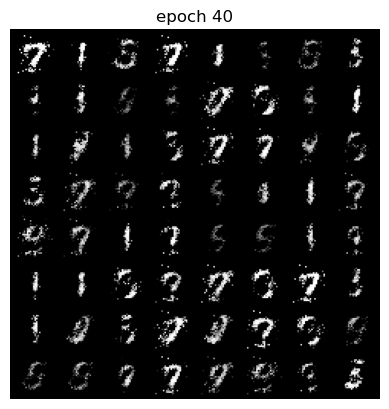

Epoch 40 of 200
Generator loss: 3.01150548, Discriminator loss: 0.43856309


118it [00:46,  2.54it/s]                         


Epoch 41 of 200
Generator loss: 2.82936535, Discriminator loss: 0.55848886


118it [00:47,  2.50it/s]                         


Epoch 42 of 200
Generator loss: 2.82821193, Discriminator loss: 0.54428736


118it [00:47,  2.50it/s]                         


Epoch 43 of 200
Generator loss: 2.82461934, Discriminator loss: 0.52608484


118it [00:47,  2.50it/s]                         


Epoch 44 of 200
Generator loss: 2.73075284, Discriminator loss: 0.57321197


118it [00:47,  2.50it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


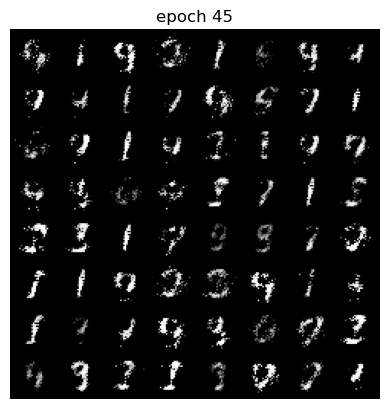

Epoch 45 of 200
Generator loss: 2.87820060, Discriminator loss: 0.52481493


118it [00:47,  2.47it/s]                         


Epoch 46 of 200
Generator loss: 2.68216441, Discriminator loss: 0.57057555


118it [00:50,  2.35it/s]                         


Epoch 47 of 200
Generator loss: 2.33907008, Discriminator loss: 0.66533344


118it [00:45,  2.60it/s]                         


Epoch 48 of 200
Generator loss: 2.56127937, Discriminator loss: 0.58877563


118it [00:45,  2.59it/s]                         


Epoch 49 of 200
Generator loss: 2.64841214, Discriminator loss: 0.62330428


118it [00:42,  2.75it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


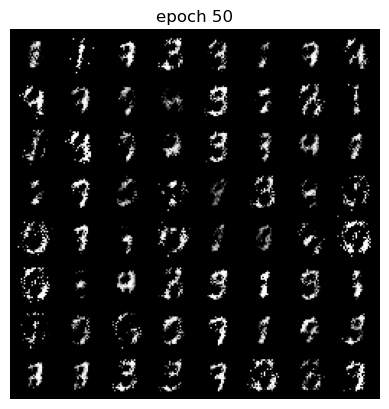

Epoch 50 of 200
Generator loss: 2.83254835, Discriminator loss: 0.58969320


118it [00:46,  2.54it/s]                         


Epoch 51 of 200
Generator loss: 2.79706655, Discriminator loss: 0.52940203


118it [00:46,  2.53it/s]                         


Epoch 52 of 200
Generator loss: 3.00340724, Discriminator loss: 0.52378059


118it [00:45,  2.57it/s]                         


Epoch 53 of 200
Generator loss: 2.93186408, Discriminator loss: 0.52903793


118it [00:46,  2.52it/s]                         


Epoch 54 of 200
Generator loss: 2.87761421, Discriminator loss: 0.55859817


118it [00:45,  2.60it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


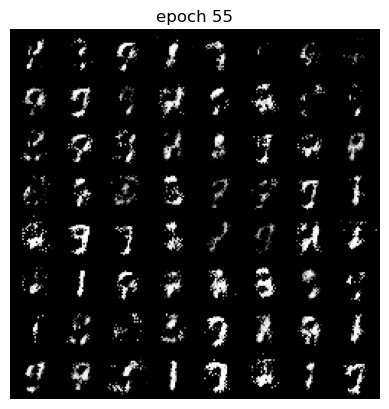

Epoch 55 of 200
Generator loss: 2.77200669, Discriminator loss: 0.56451994


118it [00:46,  2.52it/s]                         


Epoch 56 of 200
Generator loss: 2.74950905, Discriminator loss: 0.55170688


118it [00:45,  2.57it/s]                         


Epoch 57 of 200
Generator loss: 2.77740764, Discriminator loss: 0.61478940


118it [00:44,  2.66it/s]                         


Epoch 58 of 200
Generator loss: 2.74054225, Discriminator loss: 0.60801432


118it [00:46,  2.53it/s]                         


Epoch 59 of 200
Generator loss: 2.67143762, Discriminator loss: 0.58985380


118it [00:42,  2.75it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


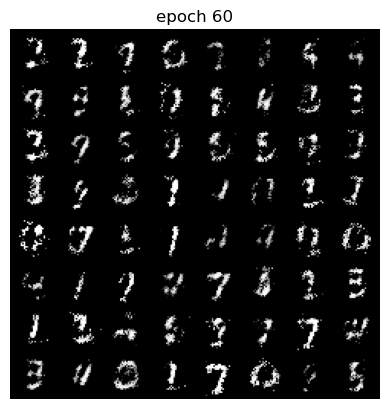

Epoch 60 of 200
Generator loss: 2.73588226, Discriminator loss: 0.54637350


118it [00:44,  2.62it/s]                         


Epoch 61 of 200
Generator loss: 2.76149725, Discriminator loss: 0.57038016


118it [00:46,  2.52it/s]                         


Epoch 62 of 200
Generator loss: 2.54238379, Discriminator loss: 0.60641014


118it [00:46,  2.53it/s]                         


Epoch 63 of 200
Generator loss: 2.72899116, Discriminator loss: 0.59000067


118it [00:46,  2.52it/s]                         


Epoch 64 of 200
Generator loss: 2.58091565, Discriminator loss: 0.62983505


118it [00:46,  2.56it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


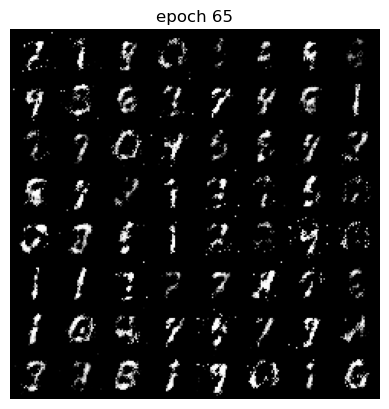

Epoch 65 of 200
Generator loss: 2.82023874, Discriminator loss: 0.59856008


118it [00:46,  2.55it/s]                         


Epoch 66 of 200
Generator loss: 2.62173107, Discriminator loss: 0.61079871


118it [00:45,  2.57it/s]                         


Epoch 67 of 200
Generator loss: 2.61801623, Discriminator loss: 0.57717839


118it [00:46,  2.52it/s]                         


Epoch 68 of 200
Generator loss: 2.79948445, Discriminator loss: 0.58030900


118it [00:47,  2.50it/s]                         


Epoch 69 of 200
Generator loss: 2.66227200, Discriminator loss: 0.60712006


118it [00:46,  2.52it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


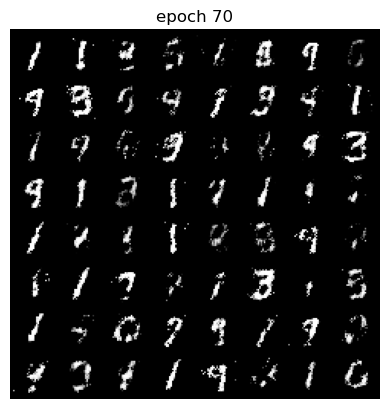

Epoch 70 of 200
Generator loss: 2.52183457, Discriminator loss: 0.66930067


118it [00:47,  2.50it/s]                         


Epoch 71 of 200
Generator loss: 2.44715523, Discriminator loss: 0.62038853


118it [00:48,  2.42it/s]                         


Epoch 72 of 200
Generator loss: 2.52051227, Discriminator loss: 0.61042814


118it [00:49,  2.40it/s]                         


Epoch 73 of 200
Generator loss: 2.39649138, Discriminator loss: 0.63380002


118it [00:43,  2.69it/s]                         


Epoch 74 of 200
Generator loss: 2.51044639, Discriminator loss: 0.60256256


118it [00:43,  2.70it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


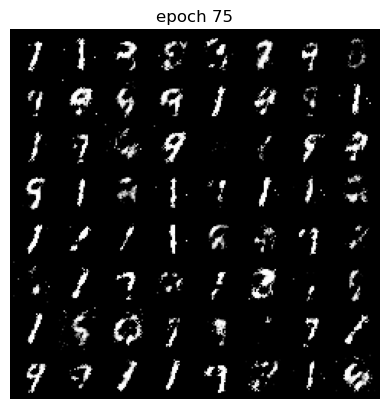

Epoch 75 of 200
Generator loss: 2.40795694, Discriminator loss: 0.60991216


118it [00:42,  2.75it/s]                         


Epoch 76 of 200
Generator loss: 2.43871114, Discriminator loss: 0.63217137


118it [00:43,  2.74it/s]                         


Epoch 77 of 200
Generator loss: 2.42865297, Discriminator loss: 0.63047229


118it [00:44,  2.64it/s]                         


Epoch 78 of 200
Generator loss: 2.41038450, Discriminator loss: 0.67490099


118it [00:43,  2.69it/s]                         


Epoch 79 of 200
Generator loss: 2.25599111, Discriminator loss: 0.68005579


118it [00:45,  2.58it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


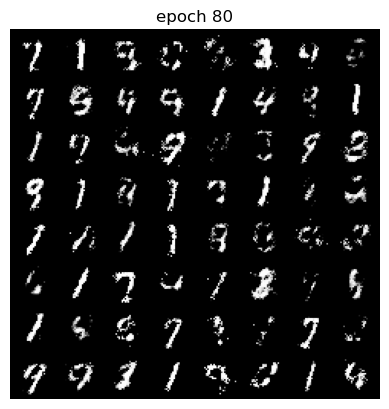

Epoch 80 of 200
Generator loss: 2.16887010, Discriminator loss: 0.71727142


118it [00:41,  2.82it/s]                         


Epoch 81 of 200
Generator loss: 2.30809451, Discriminator loss: 0.68350554


118it [00:46,  2.56it/s]                         


Epoch 82 of 200
Generator loss: 2.19764313, Discriminator loss: 0.71146809


118it [00:48,  2.45it/s]                         


Epoch 83 of 200
Generator loss: 2.32529282, Discriminator loss: 0.66413995


118it [00:42,  2.78it/s]                         


Epoch 84 of 200
Generator loss: 2.11291306, Discriminator loss: 0.71880734


118it [00:46,  2.54it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


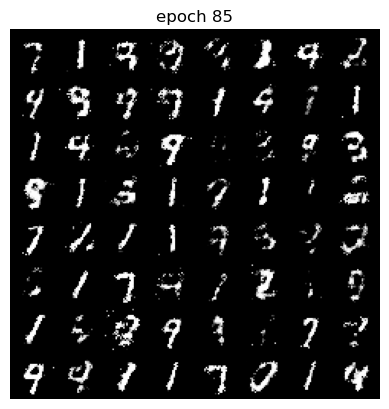

Epoch 85 of 200
Generator loss: 2.23764662, Discriminator loss: 0.69229661


118it [00:47,  2.49it/s]                         


Epoch 86 of 200
Generator loss: 2.24037327, Discriminator loss: 0.70582484


118it [00:42,  2.77it/s]                         


Epoch 87 of 200
Generator loss: 2.14179880, Discriminator loss: 0.72375948


118it [00:46,  2.51it/s]                         


Epoch 88 of 200
Generator loss: 2.24217064, Discriminator loss: 0.70375090


118it [00:43,  2.72it/s]                         


Epoch 89 of 200
Generator loss: 2.11270337, Discriminator loss: 0.74122925


118it [00:47,  2.51it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


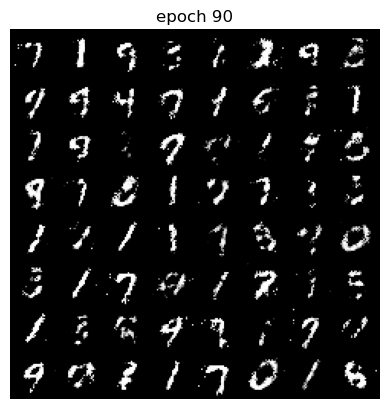

Epoch 90 of 200
Generator loss: 2.09507859, Discriminator loss: 0.80147148


118it [00:42,  2.80it/s]                         


Epoch 91 of 200
Generator loss: 1.98085384, Discriminator loss: 0.79256621


118it [00:44,  2.63it/s]                         


Epoch 92 of 200
Generator loss: 1.98950792, Discriminator loss: 0.78722615


118it [00:46,  2.54it/s]                         


Epoch 93 of 200
Generator loss: 1.99490880, Discriminator loss: 0.79517864


118it [00:45,  2.57it/s]                         


Epoch 94 of 200
Generator loss: 1.99890568, Discriminator loss: 0.75028594


118it [00:49,  2.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


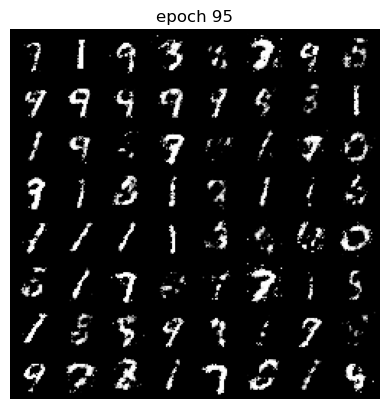

Epoch 95 of 200
Generator loss: 1.91120495, Discriminator loss: 0.81167374


118it [00:46,  2.54it/s]                         


Epoch 96 of 200
Generator loss: 1.94574953, Discriminator loss: 0.81257249


118it [00:46,  2.54it/s]                         


Epoch 97 of 200
Generator loss: 1.90226315, Discriminator loss: 0.82461355


118it [00:46,  2.55it/s]                         


Epoch 98 of 200
Generator loss: 1.97457541, Discriminator loss: 0.80061252


118it [00:50,  2.35it/s]                         


Epoch 99 of 200
Generator loss: 1.91667192, Discriminator loss: 0.80633877


118it [00:45,  2.62it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


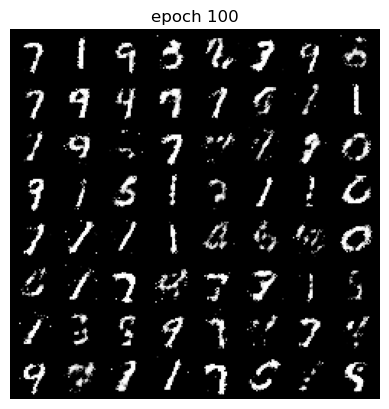

Epoch 100 of 200
Generator loss: 2.01369615, Discriminator loss: 0.78287806


118it [00:44,  2.68it/s]                         


Epoch 101 of 200
Generator loss: 1.93751981, Discriminator loss: 0.81816354


118it [00:43,  2.72it/s]                         


Epoch 102 of 200
Generator loss: 1.94703528, Discriminator loss: 0.80928901


118it [00:46,  2.55it/s]                         


Epoch 103 of 200
Generator loss: 1.92557299, Discriminator loss: 0.82131589


118it [00:43,  2.73it/s]                         


Epoch 104 of 200
Generator loss: 1.99432740, Discriminator loss: 0.81221264


118it [00:43,  2.70it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


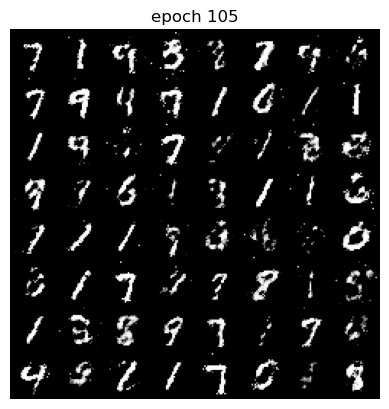

Epoch 105 of 200
Generator loss: 1.97294056, Discriminator loss: 0.79148660


118it [00:45,  2.57it/s]                         


Epoch 106 of 200
Generator loss: 1.89139824, Discriminator loss: 0.80289972


118it [00:46,  2.53it/s]                         


Epoch 107 of 200
Generator loss: 1.88173061, Discriminator loss: 0.83200542


118it [00:46,  2.56it/s]                         


Epoch 108 of 200
Generator loss: 1.84720224, Discriminator loss: 0.82974805


118it [00:46,  2.53it/s]                         


Epoch 109 of 200
Generator loss: 1.91623100, Discriminator loss: 0.83253216


118it [00:46,  2.53it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


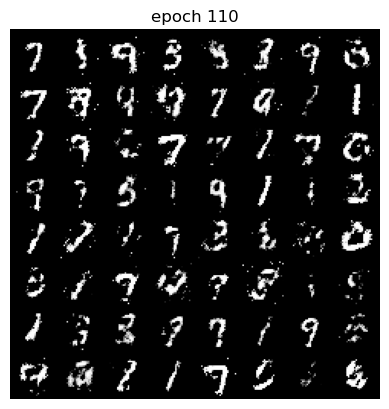

Epoch 110 of 200
Generator loss: 1.89695783, Discriminator loss: 0.86465548


118it [00:50,  2.35it/s]                         


Epoch 111 of 200
Generator loss: 1.79408555, Discriminator loss: 0.86417003


118it [00:46,  2.53it/s]                         


Epoch 112 of 200
Generator loss: 1.84013051, Discriminator loss: 0.87271653


118it [00:45,  2.57it/s]                         


Epoch 113 of 200
Generator loss: 1.81017598, Discriminator loss: 0.84594287


118it [00:46,  2.52it/s]                         


Epoch 114 of 200
Generator loss: 1.82781526, Discriminator loss: 0.85482610


118it [00:46,  2.53it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


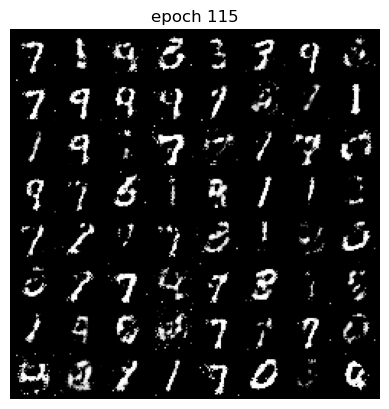

Epoch 115 of 200
Generator loss: 1.87303041, Discriminator loss: 0.85258700


118it [00:45,  2.60it/s]                         


Epoch 116 of 200
Generator loss: 1.86742286, Discriminator loss: 0.84643109


118it [00:45,  2.60it/s]                         


Epoch 117 of 200
Generator loss: 1.82715370, Discriminator loss: 0.83459626


118it [00:46,  2.52it/s]                         


Epoch 118 of 200
Generator loss: 1.82956654, Discriminator loss: 0.84612980


118it [00:43,  2.71it/s]                         


Epoch 119 of 200
Generator loss: 1.87245839, Discriminator loss: 0.84836834


118it [00:46,  2.53it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


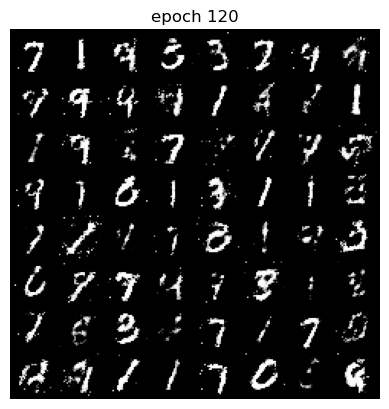

Epoch 120 of 200
Generator loss: 1.85197568, Discriminator loss: 0.84243478


118it [00:46,  2.53it/s]                         


Epoch 121 of 200
Generator loss: 1.80055930, Discriminator loss: 0.87637340


118it [00:46,  2.54it/s]                         


Epoch 122 of 200
Generator loss: 1.79148287, Discriminator loss: 0.86956725


118it [00:44,  2.65it/s]                         


Epoch 123 of 200
Generator loss: 1.76733150, Discriminator loss: 0.85431357


118it [00:46,  2.54it/s]                         


Epoch 124 of 200
Generator loss: 1.76866080, Discriminator loss: 0.86703972


118it [00:43,  2.72it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


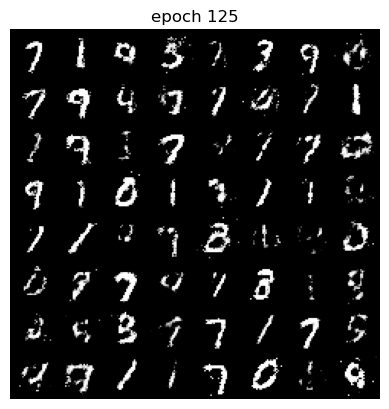

Epoch 125 of 200
Generator loss: 1.77322832, Discriminator loss: 0.87829759


118it [00:46,  2.56it/s]                         


Epoch 126 of 200
Generator loss: 1.69501018, Discriminator loss: 0.90535509


118it [00:46,  2.54it/s]                         


Epoch 127 of 200
Generator loss: 1.73211003, Discriminator loss: 0.89437710


118it [00:45,  2.59it/s]                         


Epoch 128 of 200
Generator loss: 1.73315088, Discriminator loss: 0.89380669


118it [00:44,  2.65it/s]                         


Epoch 129 of 200
Generator loss: 1.69147968, Discriminator loss: 0.88572562


118it [00:46,  2.52it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


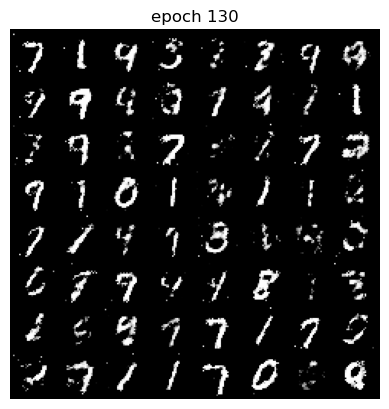

Epoch 130 of 200
Generator loss: 1.72681082, Discriminator loss: 0.90139539


118it [00:46,  2.55it/s]                         


Epoch 131 of 200
Generator loss: 1.71058876, Discriminator loss: 0.90194878


118it [00:45,  2.57it/s]                         


Epoch 132 of 200
Generator loss: 1.60533481, Discriminator loss: 0.92690856


118it [00:46,  2.51it/s]                         


Epoch 133 of 200
Generator loss: 1.65856685, Discriminator loss: 0.91699986


118it [00:44,  2.65it/s]                         


Epoch 134 of 200
Generator loss: 1.64490794, Discriminator loss: 0.92306491


118it [00:45,  2.61it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


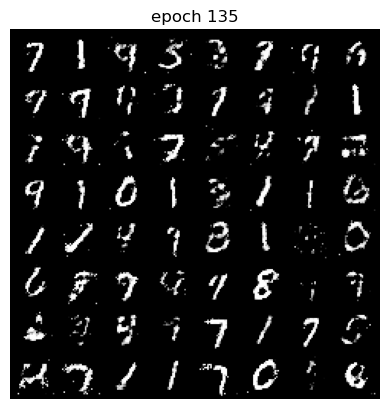

Epoch 135 of 200
Generator loss: 1.58533839, Discriminator loss: 0.94770272


118it [00:45,  2.62it/s]                         


Epoch 136 of 200
Generator loss: 1.61668311, Discriminator loss: 0.93480453


118it [00:42,  2.75it/s]                         


Epoch 137 of 200
Generator loss: 1.58365886, Discriminator loss: 0.94681539


118it [00:44,  2.66it/s]                         


Epoch 138 of 200
Generator loss: 1.59888328, Discriminator loss: 0.94579145


118it [00:45,  2.59it/s]                         


Epoch 139 of 200
Generator loss: 1.56876227, Discriminator loss: 0.95863385


118it [00:45,  2.60it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


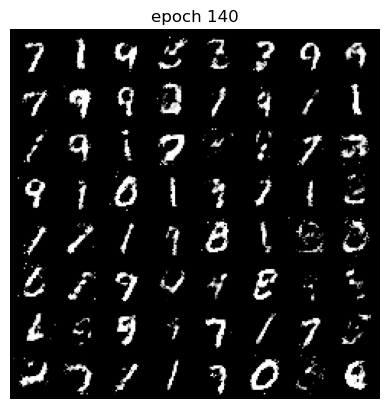

Epoch 140 of 200
Generator loss: 1.52720078, Discriminator loss: 0.96664043


118it [00:43,  2.70it/s]                         


Epoch 141 of 200
Generator loss: 1.62907729, Discriminator loss: 0.96902610


118it [00:42,  2.79it/s]                         


Epoch 142 of 200
Generator loss: 1.52444567, Discriminator loss: 0.97691622


118it [00:45,  2.58it/s]                         


Epoch 143 of 200
Generator loss: 1.51798944, Discriminator loss: 0.96633989


118it [00:46,  2.56it/s]                         


Epoch 144 of 200
Generator loss: 1.52390981, Discriminator loss: 0.97254465


118it [00:47,  2.48it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


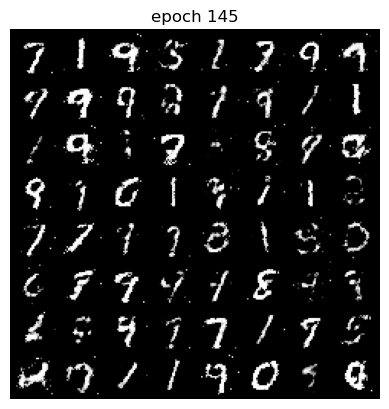

Epoch 145 of 200
Generator loss: 1.44242489, Discriminator loss: 0.99254967


118it [00:45,  2.57it/s]                         


Epoch 146 of 200
Generator loss: 1.50707583, Discriminator loss: 0.99212838


118it [00:46,  2.55it/s]                         


Epoch 147 of 200
Generator loss: 1.48198086, Discriminator loss: 0.98664787


118it [00:46,  2.55it/s]                         


Epoch 148 of 200
Generator loss: 1.50319459, Discriminator loss: 1.00236493


118it [00:46,  2.56it/s]                         


Epoch 149 of 200
Generator loss: 1.44714856, Discriminator loss: 1.01797410


118it [00:45,  2.57it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


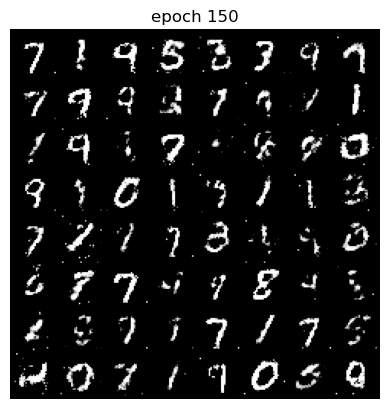

Epoch 150 of 200
Generator loss: 1.41368006, Discriminator loss: 1.02025285


118it [00:45,  2.57it/s]                         


Epoch 151 of 200
Generator loss: 1.47503143, Discriminator loss: 0.98049047


118it [00:46,  2.56it/s]                         


Epoch 152 of 200
Generator loss: 1.47301862, Discriminator loss: 1.00480940


118it [00:45,  2.59it/s]                         


Epoch 153 of 200
Generator loss: 1.44461462, Discriminator loss: 1.00968417


118it [00:45,  2.57it/s]                         


Epoch 154 of 200
Generator loss: 1.46961508, Discriminator loss: 0.98237288


118it [00:46,  2.52it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


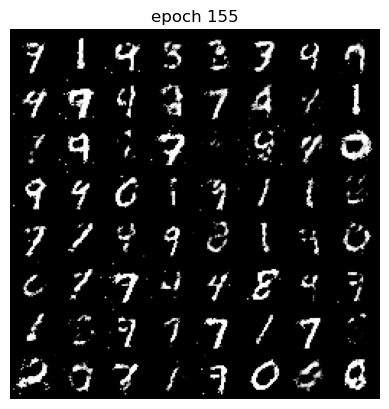

Epoch 155 of 200
Generator loss: 1.52778980, Discriminator loss: 1.00327202


118it [00:46,  2.55it/s]                         


Epoch 156 of 200
Generator loss: 1.40996614, Discriminator loss: 1.00374824


118it [00:46,  2.56it/s]                         


Epoch 157 of 200
Generator loss: 1.48287103, Discriminator loss: 1.00510773


118it [00:46,  2.55it/s]                         


Epoch 158 of 200
Generator loss: 1.46882665, Discriminator loss: 1.01166448


118it [00:45,  2.57it/s]                         


Epoch 159 of 200
Generator loss: 1.45499401, Discriminator loss: 1.00284586


118it [00:45,  2.58it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


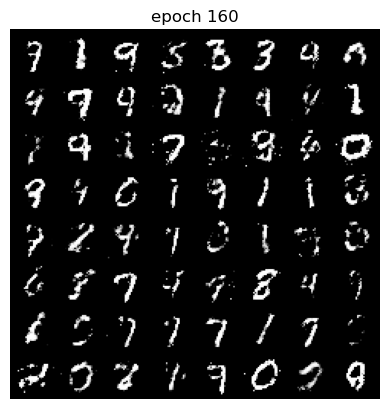

Epoch 160 of 200
Generator loss: 1.43368605, Discriminator loss: 1.01178227


118it [00:45,  2.57it/s]                         


Epoch 161 of 200
Generator loss: 1.48985951, Discriminator loss: 0.99459657


118it [00:45,  2.57it/s]                         


Epoch 162 of 200
Generator loss: 1.42423577, Discriminator loss: 1.00340152


118it [00:45,  2.57it/s]                         


Epoch 163 of 200
Generator loss: 1.42546059, Discriminator loss: 1.00908147


118it [00:46,  2.54it/s]                         


Epoch 164 of 200
Generator loss: 1.41124802, Discriminator loss: 1.02182608


118it [00:46,  2.55it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


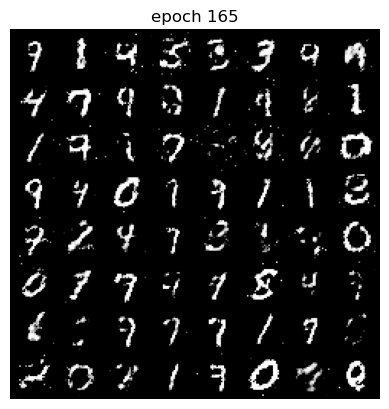

Epoch 165 of 200
Generator loss: 1.39800469, Discriminator loss: 1.01842557


118it [00:45,  2.58it/s]                         


Epoch 166 of 200
Generator loss: 1.43779903, Discriminator loss: 1.02622991


118it [00:46,  2.56it/s]                         


Epoch 167 of 200
Generator loss: 1.40611271, Discriminator loss: 1.03291548


118it [00:46,  2.56it/s]                         


Epoch 168 of 200
Generator loss: 1.37284659, Discriminator loss: 1.04595320


118it [00:46,  2.56it/s]                         


Epoch 169 of 200
Generator loss: 1.40388410, Discriminator loss: 1.02961236


118it [00:45,  2.58it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


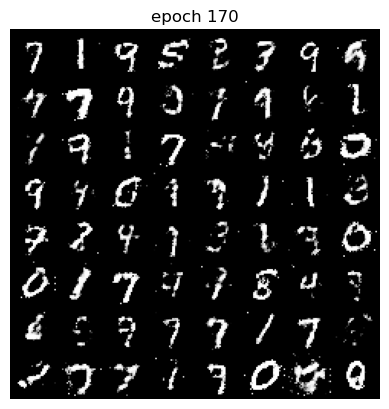

Epoch 170 of 200
Generator loss: 1.42477343, Discriminator loss: 1.01184763


118it [00:46,  2.55it/s]                         


Epoch 171 of 200
Generator loss: 1.35788093, Discriminator loss: 1.04258860


118it [00:45,  2.57it/s]                         


Epoch 172 of 200
Generator loss: 1.35844432, Discriminator loss: 1.04321839


118it [00:50,  2.33it/s]                         


Epoch 173 of 200
Generator loss: 1.36110239, Discriminator loss: 1.06013942


118it [00:49,  2.39it/s]                         


Epoch 174 of 200
Generator loss: 1.35559802, Discriminator loss: 1.06699937


118it [00:46,  2.55it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


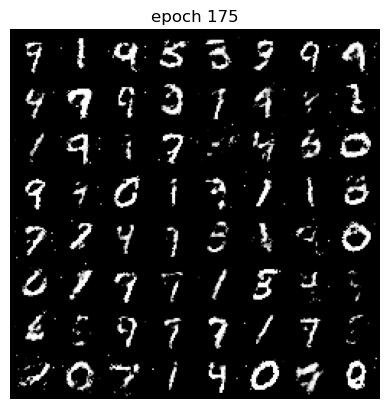

Epoch 175 of 200
Generator loss: 1.30884237, Discriminator loss: 1.06040768


118it [00:46,  2.55it/s]                         


Epoch 176 of 200
Generator loss: 1.33840999, Discriminator loss: 1.04840528


118it [00:46,  2.55it/s]                         


Epoch 177 of 200
Generator loss: 1.34336192, Discriminator loss: 1.03851599


118it [00:46,  2.56it/s]                         


Epoch 178 of 200
Generator loss: 1.32680846, Discriminator loss: 1.05736474


118it [00:45,  2.59it/s]                         


Epoch 179 of 200
Generator loss: 1.35008122, Discriminator loss: 1.06344473


118it [00:46,  2.55it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


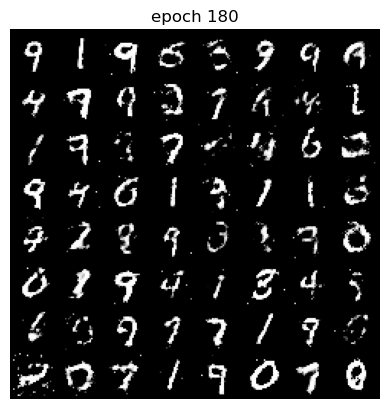

Epoch 180 of 200
Generator loss: 1.36156070, Discriminator loss: 1.05269886


118it [00:47,  2.50it/s]                         


Epoch 181 of 200
Generator loss: 1.31594751, Discriminator loss: 1.05638500


118it [00:46,  2.56it/s]                         


Epoch 182 of 200
Generator loss: 1.34802756, Discriminator loss: 1.04259178


118it [00:46,  2.54it/s]                         


Epoch 183 of 200
Generator loss: 1.29832557, Discriminator loss: 1.06285323


118it [00:45,  2.57it/s]                         


Epoch 184 of 200
Generator loss: 1.31296246, Discriminator loss: 1.07703002


118it [00:45,  2.58it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


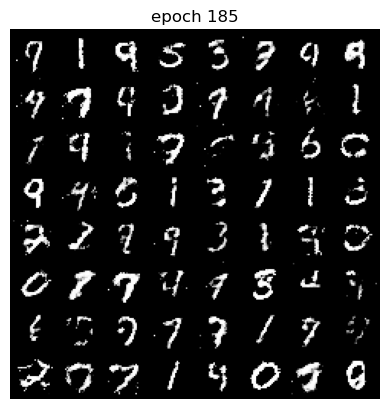

Epoch 185 of 200
Generator loss: 1.26616001, Discriminator loss: 1.10186489


118it [00:46,  2.56it/s]                         


Epoch 186 of 200
Generator loss: 1.28963099, Discriminator loss: 1.09078458


118it [00:43,  2.69it/s]                         


Epoch 187 of 200
Generator loss: 1.24583346, Discriminator loss: 1.09518092


118it [00:41,  2.82it/s]                         


Epoch 188 of 200
Generator loss: 1.32006038, Discriminator loss: 1.09361113


118it [00:42,  2.80it/s]                         


Epoch 189 of 200
Generator loss: 1.25803362, Discriminator loss: 1.09289327


118it [00:44,  2.64it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


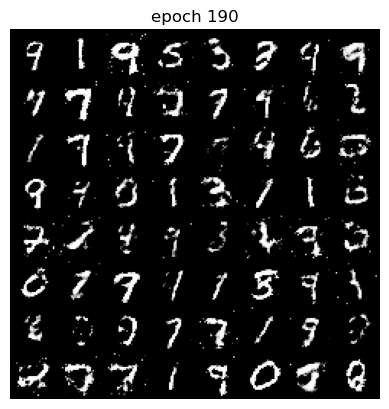

Epoch 190 of 200
Generator loss: 1.27975810, Discriminator loss: 1.09358126


118it [00:46,  2.56it/s]                         


Epoch 191 of 200
Generator loss: 1.24708427, Discriminator loss: 1.09507376


118it [00:47,  2.50it/s]                         


Epoch 192 of 200
Generator loss: 1.21946680, Discriminator loss: 1.11403762


118it [00:44,  2.66it/s]                         


Epoch 193 of 200
Generator loss: 1.26381612, Discriminator loss: 1.09030901


118it [00:43,  2.70it/s]                         


Epoch 194 of 200
Generator loss: 1.28593826, Discriminator loss: 1.08150409


118it [00:46,  2.54it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


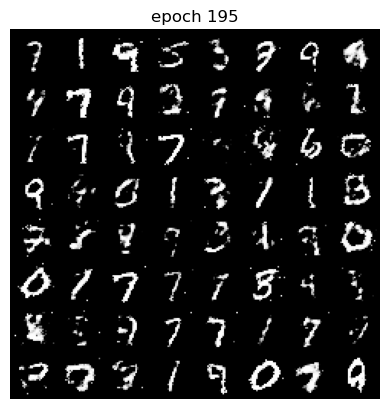

Epoch 195 of 200
Generator loss: 1.27913292, Discriminator loss: 1.08016945


118it [00:43,  2.71it/s]                         


Epoch 196 of 200
Generator loss: 1.27129569, Discriminator loss: 1.09825168


118it [00:40,  2.95it/s]                         


Epoch 197 of 200
Generator loss: 1.30492909, Discriminator loss: 1.08723693


118it [00:45,  2.61it/s]                         


Epoch 198 of 200
Generator loss: 1.26187208, Discriminator loss: 1.10503228


118it [00:47,  2.47it/s]                         


Epoch 199 of 200
Generator loss: 1.25778132, Discriminator loss: 1.09994112


118it [00:47,  2.48it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


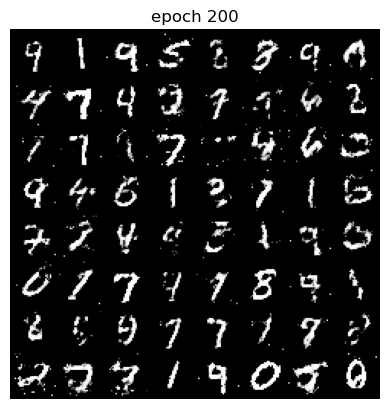

Epoch 200 of 200
Generator loss: 1.25646880, Discriminator loss: 1.09573581


In [55]:
torch.manual_seed(7777)
def generator_loss(output):
    return criterion(output, label_real(output.size(0)))          # Loss for Ques 1->a
#   return torch.log(label_real(output.size(0)) - output).mean()  # Uncomment for Calcluation generetor loss for Ques 1->b

def discriminator_loss(output_real, output_fake):
    real_loss = criterion(output_real, label_real(output_real.size(0)))
    fake_loss = criterion(output_fake, label_fake(output_fake.size(0)))
    total_loss = real_loss + fake_loss
    return total_loss

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        # Train Discriminator
        real_images, _ = data
        b_size = real_images.size(0)
        real_images = real_images.to(device)
        noise1 = create_noise(b_size, nz)
        fake_images = generator(noise1)
        
        # Update discriminator
        optim_d.zero_grad()
        output_real = discriminator(real_images)
        output_fake = discriminator(fake_images)
        loss_d1 = discriminator_loss(output_real, output_fake)
        loss_d1.backward()
        optim_d.step()

        # Train Generator
        noise2 = create_noise(b_size, nz)
        fake_images = generator(noise2)
        
        # Update generator
        optim_g.zero_grad()
        output = discriminator(fake_images)
        loss_g1 = generator_loss(output)
        loss_g1.backward()
        optim_g.step()

        # Record losses
        loss_g += loss_g1.item()
        loss_d += loss_d1.item()
        ######################################
         # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0 or epoch == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [56]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [57]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

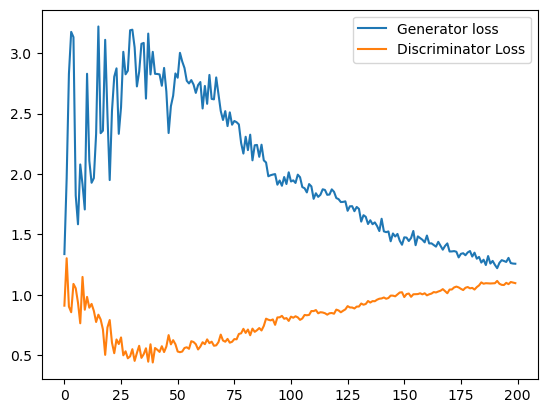

In [58]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')